## Ben Kosa's attempt for Google's Individual Sign Language Recognition (ISLR) Kaggle Competition

## **Let's First Load our Data In and Visualize It**

In [2]:
import os

import numpy as np
import pandas as pd
from tqdm import tqdm  # To give us that sweet progress bar during training/testing
import json

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Sci-kit libraries to help with mundane splitting of data and calculating accuracy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import math
import cv2
import random

In [2]:
DATA_PATH = "/kaggle/input/asl-signs/"
LANDMARK_DATA_DIR = "/kaggle/input/asl-signs/train_landmark_files"
TRAIN_FILE = "/kaggle/input/asl-signs/train.csv"
label_map = json.load(open("/kaggle/input/asl-signs/sign_to_prediction_index_map.json", "r"))

## Our data:

The data we're provided for this challenge is a collection of hand and facial landmarks generated by Mediapipe (v.0.9.0.1) on roughly 100k videos of isolated signs performed by 21 Deaf signers from a vocabulary of 250-signs (meaning 250 classes).

Each training/testing instance can be thought of as (num_frames, 528, 3), where 528 is the total number of landmarks that Mediapipe Holistic maps onto the body. In other words, each data instance is a video of someone performing exactly one sign (or word in ASL). Each video has num_frames number of frames in it and each of the 528 landmarks is a coordinate in 3D space (i.e. x, y, z float values). 

In [3]:
# Utilities for Loading Our Data
ROWS_PER_FRAME = 543  # number of landmarks per frame

def load_relevant_data_subset_with_imputation(pq_path):
    """
    Loads our data and replaces missing data (NaNs) with zeros.
    """
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    data.replace(np.nan, 0, inplace=True)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float16)

def load_relevant_data_subset(pq_path):
    """
    Just loads our data (without replacing missing data with zeros).
    """
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

def read_dict(file_path):
    path = os.path.expanduser(file_path)
    with open(path, "r") as f:
        dic = json.load(f)
    return dic

In [4]:
# Load our data
# The csv is only meant to serve as metadata for
# each actual instance of data, which is stored in a parquet file.
train_df = pd.read_csv(TRAIN_FILE)
train_df.head()  # For visualization.

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


Number of unique signers (people) in this dataset: 21

The total number of sign videos in this dataset: 94477

A plot of how many signs each person has recorded:


<AxesSubplot:>

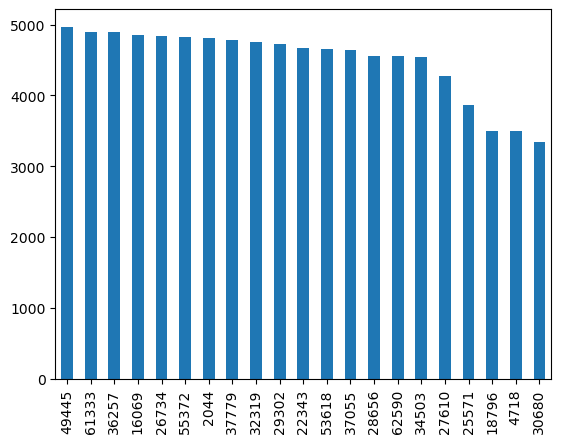

In [5]:
# Understanding the dataset a little better
print(f"Number of unique signers (people) in this dataset: {train_df.participant_id.nunique()}")
print(f"\nThe total number of sign videos in this dataset: {len(train_df)}")
print("\nA plot of how many signs each person has recorded:")
train_df.participant_id.value_counts().plot(kind="bar")

In [6]:
# Making an index_to_label mapping since the output to our model will be in indices
label_to_index = read_dict(f"../input/asl-signs/sign_to_prediction_index_map.json")
index_to_label = dict([(label_to_index[key], key) for key in label_to_index])

# Add indexed labels to our dataframe
train_df["label"] = train_df["sign"].map(lambda sign: label_to_index[sign])
train_df.head()

,path,participant_id,sequence_id,sign,label
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow,25
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait,232
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud,48
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird,23
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie,164


### Loading Our Data
- We have a function for pre-loading all of the data into a numpy array, 
- as well as a function for preloading half of the data at a time and saving them seperately since

In [7]:
NUM_VIDEOS = len(train_df)
NUM_LANDMARKS = 468 + 21 + 33 + 21  # Total = 543
NUM_LANDMARKS_NO_FACE = 21 + 33 + 21  # Total = 75
N_SAMPLES = 50

In [ ]:
"""
Go through every single training instance and create training and testing datasets
in the form of a tensor in the form (n_videos, n_frames, n_landmarks * 3)
[[frame_1], [frame_2], ..., [frame_K]] video 1
[[frame_1], [frame_2], ..., [frame_K]] video 2
...
[[frame_1], [frame_2], ..., [frame_K]] video N

where each frame contains n_landmarks number of x, y, z points j:
[j0_x, j0_y, j0_z, j1_x, j1_y, j1_z, ...]

So in the end, our x_train should be size (n_videos, n_frames, n_landmarks * 3)
"""
x_train = []
y_train = []
num_frames = np.zeros(len(train_df))  # count the number of frames for each instance
for i in tqdm(range(len(train_df))):
    path = f"{DATA_PATH}{train_df.iloc[i].path}"
    data = load_relevant_data_subset_with_imputation(path)
    # TODO: If having each x, y, z point is too costly, consider creating a lower dim
    # embedding for each frame
    x_train.append(data)
    y_train.append(train_df.iloc[i].label)
#     num_frames[i] = data.shape[0]
    
train_df["num_frames"] = num_frames
x_train = np.array(x_train)
y_train = np.array(y_train)
train_df.to_csv("train.csv", index=False)  # Save our additions to our metadata

In [ ]:
train_df.to_csv("train.csv", index=False)

print(f"x_train shape: {x_train}")
print(f"y_train shape: {y_train}")

Save our numpy arrays as compressed .npy files so we don't have to load them every single time. Be sure to download this locally onto your computer once
they're saved to your kaggle/outputs/ folder. This is because after each session, Kaggle will wipe the outputs folder. To save our numpy landmark data
across different sessions, download the compressed numpy arrays locally and upload x_train and y_train (both compressed into the file "numpy_landmark_data.npy.") as a Dataset to this kaggle notebook.

In [ ]:
# Save our numpy arrays as compressed .npy files so we don't have to load them every single time
np.savez_compressed("/kaggle/working/numpy_landmark_data.npy", x_train=x_train, y_train=y_train)
# np.save("/kaggle/working/x_train.npy", x_train)
# np.save("/kaggle/working/y_train.npy", y_train)

#### **Due to limited RAM (13GB), I'll need to only load part of the data by not loading face landmarks.**

In [ ]:
"""
Add a column to our metadata dataframe that specifies the number of frames
for each video
"""
num_frames = np.zeros(len(train_df))  # count the number of frames for each instance
for i in tqdm(range(len(train_df))):
    path = f"{DATA_PATH}{train_df.iloc[i].path}"
    data = load_relevant_data_subset_with_imputation(path)
    num_frames[i] = data.shape[0]
    
train_df["num_frames"] = num_frames

In [ ]:
# If you haven't already, save this modified train_df to your output and 
# downloadit to your computer locally so that
train_df.to_csv("train_with_n_frames.csv", index=False)  # Save our additions to our metadata

In [8]:
# Load in our saved train_df and check to see if the number of frames for each video is the same. If they aren't,
# this should be ok
train_df = pd.read_csv("/kaggle/input/train-df-preloaded/train_with_n_frames.csv")
train_df.head()

,path,participant_id,sequence_id,sign,label,num_frames
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow,25,23.0
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait,232,11.0
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud,48,105.0
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird,23,12.0
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie,164,18.0


(0.0, 40.0)

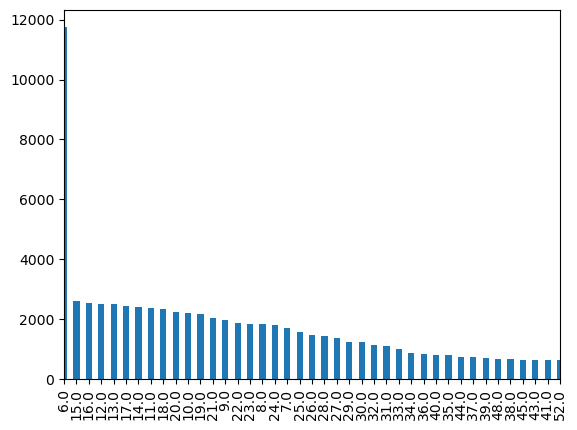

In [9]:
# It seems that if I pad the frames for all videos and try to pre-load that,
# it takes up too much data.
train_df.num_frames.value_counts().sort_values(ascending=False).plot(kind="bar")
plt.plot()
plt.xlim(0, 40)

In [10]:
"""
Only load in the hand and pose landmarks. Ignore the face landmarks.
in the form of a tensor in the form (n_videos, n_frames, n_landmarks * 3)
[[frame_1], [frame_2], ..., [frame_K]] video 1
[[frame_1], [frame_2], ..., [frame_K]] video 2
...
[[frame_1], [frame_2], ..., [frame_K]] video N

where each frame contains n_landmarks number of x, y, z points j:
[j0_x, j0_y, j0_z, j1_x, j1_y, j1_z, ...]

So in the end, our x_train should be size (n_videos, n_frames, n_landmarks * 3)

ALSO keep in mind that we want all videos to have the same number of frames, so
we will have to pad some videos with zero-frames to make them all even.
"""
# First find the maximum number of frames out of all videos in our data
# max_frames = train_df.max(axis='rows')['num_frames']  # the num of frames should be last col
max_frames = 20

data_x = []
data_y = []
for i in tqdm(range(int(len(train_df)))):
    """ Only train on videos that are max_frames frames or less"""
    if train_df.iloc[i].num_frames <= max_frames:
        path = f"{DATA_PATH}{train_df.iloc[i].path}"
        # data: (n_frames, n_landmarks, n_dims) where n_diims = 3
        data = load_relevant_data_subset_with_imputation(path)
        # For now, don't include face landmarks:
    #     face_x = x[:,:468,:].contiguous().view(-1, 468*3) ignore the face landmarks for now due to limited RAM. Keep in mind the face is still important.
        lefth_x = data[:,468:489,:].reshape(-1, 21*3)
        pose_x = data[:,489:522,:].reshape(-1, 33*3)
        righth_x = data[:,522:,:].reshape(-1, 21*3)

    #     print(f"n_frames for left hand = {lefth_x.shape[0]}")
    #     print(f"n_frames for pose = {pose_x.shape[0]}")
    #     print(f"n_frames for right hand = {righth_x.shape[0]}")
    #     print(f"num frames in train_df: {train_df.iloc[i].num_frames}")

    #     print(f"lefth_x shape: {lefth_x.shape}")
    #     print(f"pose_x shape: {pose_x.shape}")
    #     print(f"righth_x shape: {righth_x.shape}")

        # Convert any NaN landmarks to 0
        lefth_x = np.nan_to_num(lefth_x)
        pose_x = np.nan_to_num(pose_x)
        righth_x = np.nan_to_num(righth_x)

        landmarks = np.concatenate((lefth_x, pose_x, righth_x), axis=1)

        # zero pad our video with extra zero-frames until it has max_frames num
        # of frames
        n_frames_to_add = int(max_frames - train_df.iloc[i].num_frames)
        zero_frame = np.zeros(lefth_x.shape[1] + pose_x.shape[1] + righth_x.shape[1])
        padding_frames = []
        for j in range(n_frames_to_add):
            padding_frames.append(zero_frame)

        if len(padding_frames) != 0:
            landmarks = np.concatenate((landmarks, np.array(padding_frames)))
            
#         landmarks = sequential_sampling(landmarks, train_df.iloc[i].num_frames, N_SAMPLES)zz

        data_x.append(landmarks)
        data_y.append(train_df.iloc[i].label)
    
    #     print(f"len of data_x: {len(data_x)}")
    #     print(f"i = {i}")
    #     print(f"data_x[i] shape = {data_x[i].shape}")
    
data_x_no_face = np.array(data_x)
data_y_no_face = np.array(data_y)

100%|██████████| 94477/94477 [08:52<00:00, 177.40it/s]


In [11]:
print(f"data_x_no_face shape = {data_x_no_face.shape}")
print(f"data_y_no_face shape = {data_y_no_face.shape}")

data_x_no_face shape = (43993, 20, 225)
data_y_no_face shape = (43993,)


In [ ]:
# print(f"data_x shape = {data_x_no_face.reshape(len(train_df), -1, NUM_LANDMARKS_NO_FACE * 3)}")
# print(f"data_y shape = {data_y_no_face.reshape(len(train_df), -1, NUM_LANDMARKS_NO_FACE * 3)}")

In [12]:
# Save the second half of our numpy arrays as compressed 
# .npy files so we don't have to load them every single time
np.savez_compressed("/kaggle/working/numpy_landmark_data_no_face_padded", x_train_no_face=data_x, y_train_no_face=data_y)
# np.save("/kaggle/working/x_train.npy", x_train)
# np.save("/kaggle/working/y_train.npy", y_train)

In [ ]:
# Visualizing what one parquet data file looks like. NOTE, the output of 
# load_relevant_data_subset_with_imputation() is a numpy array of shape 
# (n_frames, 543, 3), where 543 is the number of landmarks and 3 corresponds to x, y, z
#
path = f"{DATA_PATH}{train_df.iloc[0].path}"
data = load_relevant_data_subset_with_imputation(path)
print(f"shape of data: {data.shape}")
print(data)

## Pretrained Action Classification Models that use Mediapipe Landmarks as input?

I looked, and unfortunately there are no action classification pretrained models that use Mediapipe Landmarks as input, thus pretraining and finetuning isn't an option for this.

## Preprocessing Utilites
Before training our model on our data, it might be useful to convert the landmark data for each video instance (num_frames, 528, 3) to a feature vector (i.e. we are doing some feature engineering in the hopes that this can improve our peformance). While we don't do this currently, it would be something to consider for the future.

In [ ]:
# Just something I was playing around with.
class SimpleFeatureEmbedding(nn.Module):
    def __init__(self):
        super(SimpleFeatureEmbedding, self).__init__()
        pass
    
    def forward(self, x):
        # The first 468 3D coordinate landmarks in each instance are from the face
        # The next 21 landmarks are from the left hand
        # The next 33 are from the "pose" landmarks (which are just on the arms, wrist,
        # and shoulders).
        
        # We are using .contiguous() to make our tensors continuous in memory 
        # for optimization.
        face_x = x[:,:468,:].contiguous().view(-1, 468*3)
        lefth_x = x[:,468:489,:].contiguous().view(-1, 21*3)
        pose_x = x[:,489:522,:].contiguous().view(-1, 33*3)
        righth_x = x[:,522:,:].contiguous().view(-1, 21*3)
        
        # Prune out any landmarks that are NaN
        lefth_x = lefth_x[~torch.any(torch.isnan(lefth_x), dim=1),:]
        righth_x = righth_x[~torch.any(torch.isnan(righth_x), dim=1),:]
        
        # Create some really simple feature embedding using the mean and std
        x1m = torch.mean(face_x, 0)
        x2m = torch.mean(lefth_x, 0)
        x3m = torch.mean(pose_x, 0)
        x4m = torch.mean(righth_x, 0)
        
        x1s = torch.std(face_x, 0)
        x2s = torch.std(lefth_x, 0)
        x3s = torch.std(pose_x, 0)
        x4s = torch.std(righth_x, 0)
        
        xfeat = torch.cat([x1m,x2m,x3m,x4m, x1s,x2s,x3s,x4s], axis=0)
        xfeat = torch.where(torch.isnan(xfeat), torch.tensor(0.0, dtype=torch.float32), xfeat)
        
        return xfeat

In [13]:
def sequential_sampling(video_instance, n_frames, n_samples):
    """
    Keep sequentially sampling num_samples from the whole video sequence
    by uniformally skipping frames.
    
    :video_instance the landmark data for one video instance
    :param num_frames the number of frames in this video instance
    :param num_samples the number of frames we want to sample 
            (the rest will be ignored)
            
            
    :return our pruned ndarray landmark data for this video instance
            
    Remember that each video instance is an ndarray of shape 
    (num_frames, num_landmarks * 3) 
    that looks like this: [[frame_1], [frame_2], ..., [frame_K]] video 1
    where each frame is an array of landmarks in the order
    [j0_x, j0_y, j0_z, j1_x, j1_y, j1_z, ...]
    """
    
    frames_to_sample = []
    if n_samples < n_frames:
        # We have too many frames and need to remove some so we only
        # have num_samples number of frames
        
        n_skips = n_frames - n_samples
        interval = n_frames // n_skips
        for i, frame_data in enumerate(video_instance):
            if i % interval == 0 and len(frames_to_sample) <= n_samples:
                # we aren't skipping this, then add it to our output
                frames_to_sample.append(frame_data)
        
    
    return frames_to_sample

In [ ]:
def pad_data(video_data):
    """
    Goes through every video and pads them with extra zero-filled frames
    so that each video instance has the same number of frames as the video in
    video_data with the largest number of frames.
    """
    
    # First find the maximum number of frames out of all videos in our data
    max_frames = 0
    for video in video_data:
        n_frames = len(video)
        if n_frames > max_frames:
            max_frames = n_frames
            
    video_data_padded = []
            
    for i, video in enumerate(video_data):
        n_frames = len(video)
        n_frames_to_pad = max_frames - n_frames
        
        frames_list = video.tolist()
        frame_pad = np.zeros(max_frames)
        for i in range(n_frames_to_pad):
            frames_list.append(frame_pad)
            
        video_data[i] = np.array(frames_list)

In [ ]:
pad_data(x_train)

In [ ]:
print(x_train.shape)

## Custom Datasets:

In [ ]:
# Just make a custom Dataset that an load in the data from each instance on the fly?
class ASLDataset(Dataset):
    def __init__(self, x, labels):
        self.x = x
        self.labels = labels
        
    def __getitem__(self, index):
        return self.x[index,:], self.labels[index]
        
    def __len__(self):
        return len(self.labels)

In [49]:
# Custom dataset for Pose-TGCN
class ASLLandmarkPreloadedDataset(Dataset):
    """
    Use this if our data is already preloaded into a numpy array.
    """
    def __init__(self, landmarks, labels):
        self.landmarks = landmarks
        self.labels = labels
        
        self.n_samples = n_samples
        
    def __getitem__(self, vid_idx):
        instance_data = self.landmarks[vid_idx]
        n_frames = instance_data.shape[0]
#         instance_data = sequential_sampling(instance_data, n_frames, self.n_samples)
        return instance_data, self.labels[vid_idx]
        
    def __len__(self):
        return len(self.labels)

In [ ]:
# Custom dataset for Pose-TGCN
class ASLLandmarkDataset(Dataset):
    def __init__(self, video_df, n_samples=50):
        """
        Use this if our data has NOT been preloaded into a numpy array
        
        :params a dataframe with the metadata for every video instance
        :params 
        """
        self.video_df = video_df
        self.n_samples = n_samples
        
    def __getitem__(self, vid_idx):
        path = f"{DATA_PATH}{self.video_df.iloc[i].path}"
        # data: (n_frames, n_landmarks, n_dims) where n_diims = 3
        data = load_relevant_data_subset_with_imputation(path)
        
        lefth_x = data[:,468:489,:].reshape(-1, 21*3)
        pose_x = data[:,489:522,:].reshape(-1, 33*3)
        righth_x = data[:,522:,:].reshape(-1, 21*3)

        # Convert any NaN landmarks to 0
        lefth_x = np.nan_to_num(lefth_x)
        pose_x = np.nan_to_num(pose_x)
        righth_x = np.nan_to_num(righth_x)

        landmarks = np.concatenate((lefth_x, pose_x, righth_x), axis=1)

        # zero pad our video with extra zero-frames until it has max_frames num
        # of frames
        n_frames_to_add = int(max_frames - train_df.iloc[i].num_frames)
        zero_frame = np.zeros(lefth_x.shape[1] + pose_x.shape[1] + righth_x.shape[1])
        padding_frames = []
        for j in range(n_frames_to_add):
            padding_frames.append(zero_frame)

        if len(padding_frames) != 0:
            landmarks = np.concatenate((landmarks, np.array(padding_frames)))
            
        n_frames = instance_data.shape[0]
        instance_data = sequential_sampling(instance_data, n_frames, self.n_samples)
        return self.instance_data, self.sign_labels[vid_idx]
        
    def __len__(self):
        return len(self.labels)

In [ ]:
# Dataloader for SPOTER Network
class SpoterDataset(Dataset):
    """
    A custom Dataset for the data that we input into our SPOTER Network.
    The data will randomly undergo augmentation before being used.
    """
    def __init__(self, landmarks, labels, augmentations_prob=0.5):
        self.landmarks = landmarks
        self.labels = labels
        self.augmentations_prob = augmentations_prob
        
        
    def __getitem__(self, vid_idx):
        instance_data = self.landmarks[vid_idx]
        n_frames = instance_data.shape[0]
        if random.random() < self.augmentation_prob:
            # If augmenting the data is randomly chosen, we then randomly
            # apply either rotation, squeezing, or perspective shift transforms
            # to all the landmarks in each frame. 
            rand_aug = random.randrange(3)
            if rand_aug == 0:
                augment_rotate()
                
                aug_instance_data = augment_rotate(instance)
        return instance_data, self.labels[vid_idx]
        
    def __len__(self):
        return len(self.labels)

## Our Models:

### Game Plan:
For this final project, I am to compare the effectiveness of three different machine learning models on the ASL-Skeleton data provided by this kaggle competition:
1. a simple Pose-LSTM network (or Pose-GRU if time allows)
2. Pose-TGCN - https://arxiv.org/abs/1910.11006
3. SPOTTER (Sign POse-based TransformER) - A slightly modified Transformer (https://paperswithcode.com/paper/sign-pose-based-transformer-for-word-level)

### 1. LSTM Pose Model

In [71]:
class PoseLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, labels_dim, layer_num):
        super(PoseLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = labels_dim
        
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, layer_num)
#         self.batch_norm = nn.BatchNorm1d(32)
        self.hidden2label = torch.nn.Linear(hidden_dim, labels_dim)
        
    def forward(self, landmarks):
#         x = self.batch_norm(landmarks)
        lstm_out, hidden = self.lstm(landmarks)
        label_space = self.hidden2label(self.hidden_dim, self.labels_dim)
        label_scores = F.log_softmax(label_space, dim=1)
        return label_scores

### 2. Pose-Based Temporal Graph Convolution Network (Pose-TGCN)

From https://arxiv.org/abs/1910.11006

**NOTE** Pose-TGCN is NOT on torch.hub, unlike ResNet, GoogleNet, etc. So a fair amount of the code is me just copying the model into this kaggle file. If kaggle allowed for multiple files, I would intead just put this library code in a seperate file.

In [60]:
class GraphConvolution_att(nn.Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True, init_A=0):
        super(GraphConvolution_att, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        # A is a K x K adjacency matrix where K = num_vertices (or landmarks)
        self.A = Parameter(torch.FloatTensor(225, 225))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        self.A.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input):
        # AHW
        support = torch.matmul(input, self.weight)  # HW
        output = torch.matmul(self.A, support)  # g
        if self.bias is not None:
            return output + self.bias
        else:
            return output

In [61]:
class GC_Block(nn.Module):

    def __init__(self, in_features, p_dropout, bias=True, is_resi=True):
        super(GC_Block, self).__init__()
        self.in_features = in_features
        self.out_features = in_features
        self.is_resi = is_resi

        # TODO: Mess with this to work with MediaPipe Landmarks
        self.gc1 = GraphConvolution_att(in_features, in_features)
        self.bn1 = nn.BatchNorm1d(225 * in_features)

        # TODO: Mess with this to work with MediaPipe Landmarks
        self.gc2 = GraphConvolution_att(in_features, in_features)
        self.bn2 = nn.BatchNorm1d(225 * in_features)
        
        # TODO: Try adding antoher GraphConvolution_att() layer and
        # see what happens. Try Leaky ReLU instead of Tanh()?

        self.do = nn.Dropout(p_dropout)
        self.act_f = nn.Tanh()

    def forward(self, x):
        y = self.gc1(x)
        b, n, f = y.shape
        y = self.bn1(y.view(b, -1)).view(b, n, f)
        y = self.act_f(y)
        y = self.do(y)

        y = self.gc2(y)
        b, n, f = y.shape
        y = self.bn2(y.view(b, -1)).view(b, n, f)
        y = self.act_f(y)
        y = self.do(y)
        if self.is_resi:
            return y + x
        else:
            return y

In [62]:
class GCN_muti_att(nn.Module):
    def __init__(self, input_feature, hidden_feature, num_class, p_dropout, num_stage=1, is_resi=True):
        super(GCN_muti_att, self).__init__()
        self.num_stage = num_stage

        self.gc1 = GraphConvolution_att(input_feature, hidden_feature)
        self.bn1 = nn.BatchNorm1d(225 * hidden_feature)

        self.gcbs = []
        for i in range(num_stage):
            self.gcbs.append(GC_Block(hidden_feature, p_dropout=p_dropout, is_resi=is_resi))

        self.gcbs = nn.ModuleList(self.gcbs)

        # TODO: Try and add this in?
        # self.gc7 = GraphConvolution_att(hidden_feature, output_feature)

        self.do = nn.Dropout(p_dropout)
        self.act_f = nn.Tanh()

        # TODO: Try and add this in?
        # self.fc1 = nn.Linear(75 * output_feature, fc1_out)
        self.fc_out = nn.Linear(hidden_feature, num_class)

    def forward(self, x):
        y = self.gc1(x)
        b, n, f = y.shape
        y = self.bn1(y.view(b, -1)).view(b, n, f)
        y = self.act_f(y)
        y = self.do(y)

        for i in range(self.num_stage):
            y = self.gcbs[i](y)

        # y = self.gc7(y)
        out = torch.mean(y, dim=1)
        out = self.fc_out(out)

        return 

### 3. SPOTER
From https://paperswithcode.com/paper/sign-pose-based-transformer-for-word-level.

**Methodology:**
- We first concatenate all the landmarks (468 + 21 + 33 + 21 = 543) into a row vector (i.e. [j0_x, j0_y, j0_z, j1_x, j1_y, j1_z, ..., j542_x, j542_y, j542_z]) so that each frame is represented by a 543 * 3 length vector)
- If no person was located in the frame or any individual landmark could not have been filled, then zeros are filled in their place.

**Augmentations:**
- To prevent overfitting and boost generalization capability, different spatial augmentations are randomly applied (uniformally) to landmark/skeletal data during training. The spatial augmentation and its parameters are kept consistent for all frames within a sign instance.
    - *in-plane rotation*
    - *squeeze*
    - *perspective transform*
    - *sequential joint rotation*
    
- In my approach, I will only use **in-plane rotation**.

**Normalization:** Incorporates Sign Language linguistic properties; each sign is usually made within the "Signing Space" (what literature notes as SS), which is a 3D space between the waist and slightly above the signer's head, spanning transversely from elbow to elbow when both arms are kept loosely bent, and spanning outwards as far as the signer can reach.

***NOTE: MY approach does NOT use Normalization***

***NOTE*** SPOTER is NOT on torch.hub, unlike ResNet, GoogleNet, etc. So a fair amount of the code is me just copying the model into this kaggle file. If kaggle allowed for multiple files, I would intead just put this library code in a seperate file.

***NOTE*** The code below is just code from the SPOTER paper but modified to use Mediapipe input instead of OpenPose input.

In [ ]:
import copy
from typing import Optional

#### **Utils for SPOTER**

In [ ]:
def augment_rotate(frames_data, angle_range):
    """
    Rotate each frame by a random angle up to 13 degrees with the center of rotation 
    lying in the center of the frame, which is equal to [0.5; 0.5].
    
    :param frames_data: ndarray of sequential skeletal data of the signing person
                 in the form [j0_x, j0_y, j0_z, j1_x, j1_y, j1_z, ...]
    :param angle_range: tuple containing the angle range 
                        (minimal and maximal angle in degrees) from which we
                        pick a random angle to rotate by.
                        
    :return: ndarray with augmented (by rotation) sequential skeletal data of the signing person
    """
    angle = math.radians(random.uniform(*angle_range))

    # Rotate each landmark point in the frame counterclockwise by 'angle' degrees
    # Since we have 3D coordinates, fix the z-axis and only rotate the x and y-axis
    origin_x, origin_y = (0.5, 0.5)
    for frame in frames_data:
        frame_data = frames_data[frame]
        for i in range(len(frame_data) // 2):
            px = frame_data[i]
            py = frame_data[i + 1]
            frame_data[i] = origin_x + math.cos(angle) * (px - origin_x) - math.sin(angle) * (py - origin_y)
            frame_data[i + 1] = origin_y + math.sin(angle) * (px - origin_x) - math.cos(angle) * (py - origin_y)
    
    return frames_data

In [ ]:
# def augment_shear_squeeze(frames_data, squeeze_ratio):
#     """
#     Squeeze. All the frames are squeezed from both horizontal sides. Two different random proportions up to 15% of
#     the original frame's width for both left and right side are cut.
        
#     :param frames_data: ndarray of sequential skeletal data of the signing person
#                  in the form [j0_x, j0_y, j0_z, j1_x, j1_y, j1_z, ...]
#     :param squeeze_ratio: Tuple containing the relative range from what the 
#                             proportion of the original width will be
#                             randomly chosen. These proportions will either be cut
#                             from both sides or used to construct the new projection
                            
#     :return: ndarray with squeezed sequential skeletal data of the signing person.
#     """
#     move_left = random.uniform(*squeeze_ratio)
#     move_right = random.uniform(*squeeze_ratio)

#     src = np.array(((0, 1), (1, 1), (0, 0), (1, 0)), dtype=np.float32)
#     dest = np.array(((0 + move_left, 1), (1 - move_right, 1), (0 + move_left, 0), (1 - move_right, 0)), dtype=np.float32)
#     mtx = cv2.getPerspectiveTransform(src, dest)

#     frames_data
#     augmented_landmarks = cv2.perspectiveTransform(np.array(frame_data, dtype=np.float32), mtx)

#     augmented_zero_landmark = cv2.perspectiveTransform(np.array([[[0, 0]]], dtype=np.float32), mtx)[0][0]
#     augmented_landmarks = np.stack([np.where(sub == augmented_zero_landmark, [0, 0], sub) for sub in augmented_landmarks])

#     return augmented_landmarks


In [ ]:
# def augment_shear_perspective(frame_data, squeeze_ratio):
#     """
#     Perspective transformation. The joint coordinates are projected onto a new plane with a spatially defined
#         center of projection, which simulates recording the sign video with a slight tilt. Each time, the right or left
#         side, as well as the proportion by which both the width and height will be reduced, are chosen randomly. This
#         proportion is selected from a uniform distribution on the [0; 1) interval. Subsequently, the new plane is
#         delineated by reducing the width at the desired side and the respective vertical edge (height) at both of its
#         adjacent corners.
        
#     :param frame_data: ndarray of sequential skeletal data of the signing person
#                  in the form [j0_x, j0_y, j0_z, j1_x, j1_y, j1_z, ...]
#     :param squeeze_ratio: Tuple containing the relative range from what the 
#                             proportion of the original width will be
#                             randomly chosen. These proportions will either be cut
#                             from both sides or used to construct the new projection
                            
#     :return: ndarray with perspective-shifted sequential skeletal data 
#             of the signing person.
#     """
#     move_ratio = random.uniform(*squeeze_ratio)
#     src = np.array(((0, 1), (1, 1), (0, 0), (1, 0)), dtype=np.float32)

#     if __random_pass(0.5):
#         dest = np.array(((0 + move_ratio, 1 - move_ratio), (1, 1), (0 + move_ratio, 0 + move_ratio), (1, 0)), dtype=np.float32)
#     else:
#         dest = np.array(((0, 1), (1 - move_ratio, 1 - move_ratio), (0, 0), (1 - move_ratio, 0 + move_ratio)), dtype=np.float32)

#     mtx = cv2.getPerspectiveTransform(src, dest)

#     augmented_landmarks = cv2.perspectiveTransform(np.array(frame_data, dtype=np.float32), mtx)

#     augmented_zero_landmark = cv2.perspectiveTransform(np.array([[[0, 0]]], dtype=np.float32), mtx)[0][0]
#     augmented_landmarks = np.stack([np.where(sub == augmented_zero_landmark, [0, 0], sub) for sub in augmented_landmarks])

#     return augmented_landmarks

In [ ]:
def _get_clones(mod, n):
    return nn.ModuleList([copy.deepcopy(mod) for _ in range(n)])

#### **Model**

In [ ]:
class SPOTERTransformerDecoderLayer(nn.TransformerDecoderLayer):
    """
    Edited TransformerDecoderLayer implementation omitting the redundant self-attention operation as opposed to the
    standard implementation.
    """

    def __init__(self, d_model, nhead, dim_feedforward, dropout, activation):
        super(SPOTERTransformerDecoderLayer, self).__init__(d_model, nhead, dim_feedforward, dropout, activation)

        del self.self_attn

    def forward(self, tgt: torch.Tensor, memory: torch.Tensor, tgt_mask: Optional[torch.Tensor] = None,
                memory_mask: Optional[torch.Tensor] = None, tgt_key_padding_mask: Optional[torch.Tensor] = None,
                memory_key_padding_mask: Optional[torch.Tensor] = None) -> torch.Tensor:

        tgt = tgt + self.dropout1(tgt)
        tgt = self.norm1(tgt)
        tgt2 = self.multihead_attn(tgt, memory, memory, attn_mask=memory_mask,
                                   key_padding_mask=memory_key_padding_mask)[0]
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)

        return tgt
    

In [ ]:
class SPOTER(nn.Module):
    """
    Implementation of the SPOTER (Sign POse-based TransformER) architecture for sign language recognition from sequence
    of skeletal data.
    """

    def __init__(self, num_classes, hidden_dim=55):
        super().__init__()

        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim))
        self.pos = nn.Parameter(torch.cat([self.row_embed[0].unsqueeze(0).repeat(1, 1, 1)], dim=-1).flatten(0, 1).unsqueeze(0))
        self.class_query = nn.Parameter(torch.rand(1, hidden_dim))  # This is done to get rid of the query class
        self.transformer = nn.Transformer(hidden_dim, 9, 6, 6)
        self.linear_class = nn.Linear(hidden_dim, num_classes)

        # Deactivate the initial attention decoder mechanism
        custom_decoder_layer = SPOTERTransformerDecoderLayer(self.transformer.d_model, self.transformer.nhead, 2048,
                                                             0.1, "relu")
        self.transformer.decoder.layers = _get_clones(custom_decoder_layer, self.transformer.decoder.num_layers)

    def forward(self, inputs):
        h = torch.unsqueeze(inputs.flatten(start_dim=1), 1).float()
        h = self.transformer(self.pos + h, self.class_query.unsqueeze(0)).transpose(0, 1)
        res = self.linear_class(h)

        return res

#### Data Augmentation Functions
From https://paperswithcode.com/paper/sign-pose-based-transformer-for-word-level

## Training

In [18]:
from sklearn.metrics import accuracy_score

In [ ]:
# Load our data from our pre_loaded x_train and y_train landmark ndarrays
data_x = np.load("/kaggle/working/numpy_landmark_data_80p.npz", allow_pickle=True)
data_y = np.load("/kaggle/working/numpy_landmark_data_80p.npz", allow_pickle=True)

In [19]:
data_x = data_x_no_face
data_y = data_y_no_face

In [20]:
# Create our training, val, and test sets
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.15, random_state=42)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.15, random_state=42)

train_x = torch.from_numpy(train_x)
train_y = torch.from_numpy(train_y)

val_x = torch.from_numpy(val_x)
val_y = torch.from_numpy(val_y)

test_x = torch.from_numpy(test_x)
test_y = torch.from_numpy(test_y)

In [21]:
# Print dims to make sure data was loaded in correctly
print(f"dims of train_x: {train_x.shape}")
print(f"dims of train_y: {train_y.shape}")
print(f"dims of val_x: {val_x.shape}")
print(f"dims of val_y: {val_y.shape}")
print(f"dims of test_x: {test_x.shape}")
print(f"dims of test_y: {test_y.shape}")

dims of train_x: torch.Size([31784, 20, 225])
dims of train_y: torch.Size([31784])
dims of val_x: torch.Size([5610, 20, 225])
dims of val_y: torch.Size([5610])
dims of test_x: torch.Size([6599, 20, 225])
dims of test_y: torch.Size([6599])


In [22]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


#### **Training for Pose-LSTM**

In [72]:
"""
    Training for PoseLSTM
"""
EPOCHS = 10
BATCH_SIZE = 64
FRAME_DIM = (21 + 33 + 21) * 225  # Total = 225
HIDDEN_DIM = 32  # Decrease if too much
LABELS_DIM = len(train_y)
NUM_LAYERS = 1

DROPOUT = 0.3
LOG_INTERVAL = 1

INIT_LR = 0.001
EPS = 1e-3  # term added to the denominator for Adam optim. to improve numerical stability (default: 1e-8)
DECAY = 0

train_data = ASLLandmarkPreloadedDataset(train_x, train_y)
val_data = ASLLandmarkPreloadedDataset(val_x, val_y)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

#  input_dim, hidden_dim, labels_dim, layer_num
model = PoseLSTM(FRAME_DIM, HIDDEN_DIM, LABELS_DIM, NUM_LAYERS).to(device)
opt = torch.optim.Adam(model.parameters(), lr=INIT_LR, eps=EPS, weight_decay=DECAY)
criterion = nn.CrossEntropyLoss()
sched = torch.optim.lr_scheduler.StepLR(opt, step_size=300, gamma=0.95)

for i in range(EPOCHS):
    model.train()
    
    train_loss_sum = 0.
    train_correct = 0
    train_total = 0
    train_bar = train_loader
    for x,y in train_bar:
        x = torch.Tensor(x).float().cuda()
        y = torch.Tensor(y).long().cuda()  
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        train_loss_sum += loss.item()
        train_correct += np.sum((np.argmax(y_pred.detach().cpu().numpy(), axis=1) == y.cpu().numpy()))
        train_total += 1
        sched.step()
        
    val_loss_sum = 0.
    val_correct = 0
    val_total = 0
    model.eval()
    for x,y in val_loader:
        x = torch.Tensor(x).float().cuda()
        y = torch.Tensor(y).long().cuda()
        
        with torch.no_grad():
            y_pred = model(x)
            loss = criterion(y_pred, y)
            val_loss_sum += loss.item()
            val_correct += np.sum((np.argmax(y_pred.cpu().numpy(), axis=1) == y.cpu().numpy()))
            val_total += 1
                              
    print(f"Epoch:{i} > Train Loss: {(train_loss_sum/train_total):.04f}, Train Acc: {train_correct/len(train_data):0.04f}")
    print(f"Epoch:{i} > Val Loss: {(val_loss_sum/val_total):.04f}, Val Acc: {val_correct/len(valid_data):0.04f}")
    print("="*50)

RuntimeError: input.size(-1) must be equal to input_size. Expected 16875, got 225

#### **Training for Pose-TGCN**

In [65]:
"""
    Pose-TGCN
# """
EPOCHS = 10
BATCH_SIZE = 64
HIDDEN_DIM = 64  # Decrease if too much
NUM_STAGES = 20
NUM_CLASSES = len(train_y)

NUM_SAMPLES = 20  # only skip frames during training. TODO: _ is the smallest num of frames in all of our videos
DROPOUT = 0.3
LOG_INTERVAL = 1

INIT_LR = 0.001
EPS = 1e-3  # term added to the denominator for Adam optim. to improve numerical stability (default: 1e-8)
DECAY = 0

train_data = ASLLandmarkPreloadedDataset(train_x, train_y)
val_data = ASLLandmarkPreloadedDataset(val_x, val_y)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

model = GCN_muti_att(input_feature=NUM_SAMPLES*3, hidden_feature=NUM_SAMPLES*3,
                     num_class=NUM_CLASSES, p_dropout=DROPOUT, num_stage=NUM_STAGES).to(device)
opt = torch.optim.Adam(model.parameters(), lr=INIT_LR, eps=EPS, weight_decay=DECAY)
criterion = nn.CrossEntropyLoss()
# sched = torch.optim.lr_scheduler.StepLR(opt, step_size=300, gamma=0.95)

epoch_training_losses = []  # losses for training set for every epoch
epoch_train_scores = []  # accruacy scores for training set for every epoch
epoch_val_losses = []  # losses for val set for every epoch
epoch_val_scores = []  # accuracy scores for val set for every epoch

best_acc = 0
for i in range(EPOCHS):
    model.train()
    
    losses = []
    scores = []
    train_labels = []
    train_preds = []
    
    n_samples = 0. # use this to count the total trained samples in one epoch
    for batch_idx, data in enumerate(train_loader):
        landmarks, labels = data
        landmarks = torch.Tensor(landmarks).float().to(device)
        labels = torch.Tensor(labels).long().cuda().to(device)
        
        n_samples += landmarks.size()[0]
        opt.zero_grad() 
        
        print(f"landmarks shape: {landmarks.shape}")
        out = model(landmarks)  # out has dim = (batch, num of classes)
        
        loss = criterion(y_pred, y)
        loss.backward()
        opt.step()
        
        # Compute the accuracy for this batch and add it to our list
        y_pred = torch.max(out, 1)[1]
        truths = labels.cpu().data.squeeze()
        preds = y_pred.cpu().data.squeeze()
        acc = accuracy_score(truths.numpy(), preds.numpy())
        scores.append()
        
        train_labels.extend(truths.tolist())
        train_preds.extend(y_pred.tolist())
#         sched.step()

        # show information
        if (batch_idx + 1) % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accu: {:.6f}%'.format(
                epoch + 1, n_count, len(train_loader.dataset), 100. * (batch_idx + 1) / len(train_loader), loss.item(),
                100 * step_score))
            
    """Run validation"""
    val_loss_sum = 0.
    val_correct = 0
    val_total = 0
    model.eval()
    for x,y in val_loader:
        x = torch.Tensor(x).float().cuda()
        y = torch.Tensor(y).long().cuda()
        
        with torch.no_grad():
            y_pred = model(x)
            loss = criterion(y_pred, y)
            val_loss_sum += loss.item()
            val_correct += np.sum((np.argmax(y_pred.cpu().numpy(), axis=1) == y.cpu().numpy()))
            val_total += 1
                              
    print(f"Epoch:{i} > Train Loss: {(train_loss_sum/train_total):.04f}, Train Acc: {train_correct/len(train_data):0.04f}")
    print(f"Epoch:{i} > Val Loss: {(val_loss_sum/val_total):.04f}, Val Acc: {val_correct/len(valid_data):0.04f}")
    print("="*50)

landmarks shape: torch.Size([64, 20, 225])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1280x225 and 60x60)

In [ ]:
"""
    Pose-TGCN
# """
EPOCHS = 10
BATCH_SIZE = 64
HIDDEN_DIM = 64  # Decrease if too much
NUM_STAGES = 20
NUM_CLASSES = len(train_y)

NUM_SAMPLES = 20  # only skip frames during training. TODO: _ is the smallest num of frames in all of our videos
DROPOUT = 0.3
LOG_INTERVAL = 1

INIT_LR = 0.001
EPS = 1e-3  # term added to the denominator for Adam optim. to improve numerical stability (default: 1e-8)
DECAY = 0

train_data = ASLLandmarkPreloadedDataset(train_x, train_y)
val_data = ASLLandmarkPreloadedDataset(val_x, val_y)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

model = SPOTER(num_classes=NUM_CLASSES, hidden_dim=HIDDEN_DIM).to(device)
opt = torch.optim.Adam(model.parameters(), lr=INIT_LR, eps=EPS, weight_decay=DECAY)
criterion = nn.CrossEntropyLoss()
# sched = torch.optim.lr_scheduler.StepLR(opt, step_size=300, gamma=0.95)

epoch_training_losses = []  # losses for training set for every epoch
epoch_train_scores = []  # accruacy scores for training set for every epoch
epoch_val_losses = []  # losses for val set for every epoch
epoch_val_scores = []  # accuracy scores for val set for every epoch

best_acc = 0
for i in range(EPOCHS):
    model.train()
    
    losses = []
    scores = []
    train_labels = []
    train_preds = []
    
    n_samples = 0. # use this to count the total trained samples in one epoch
    for batch_idx, data in enumerate(train_loader):
        landmarks, labels = data
        landmarks = torch.Tensor(landmarks).float().to(device)
        labels = torch.Tensor(labels).long().cuda().to(device)
        
        n_samples += landmarks.size()[0]
        opt.zero_grad() 
        
        print(f"landmarks shape: {landmarks.shape}")
        out = model(landmarks)  # out has dim = (batch, num of classes)
        
        loss = criterion(y_pred, y)
        loss.backward()
        opt.step()
        
        # Compute the accuracy for this batch and add it to our list
        y_pred = torch.max(out, 1)[1]
        truths = labels.cpu().data.squeeze()
        preds = y_pred.cpu().data.squeeze()
        acc = accuracy_score(truths.numpy(), preds.numpy())
        scores.append()
        
        train_labels.extend(truths.tolist())
        train_preds.extend(y_pred.tolist())
#         sched.step()

        # show information
        if (batch_idx + 1) % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accu: {:.6f}%'.format(
                epoch + 1, n_count, len(train_loader.dataset), 100. * (batch_idx + 1) / len(train_loader), loss.item(),
                100 * step_score))
            
    """Run validation"""
    val_loss_sum = 0.
    val_correct = 0
    val_total = 0
    model.eval()
    for x,y in val_loader:
        x = torch.Tensor(x).float().cuda()
        y = torch.Tensor(y).long().cuda()
        
        with torch.no_grad():
            y_pred = model(x)
            loss = criterion(y_pred, y)
            val_loss_sum += loss.item()
            val_correct += np.sum((np.argmax(y_pred.cpu().numpy(), axis=1) == y.cpu().numpy()))
            val_total += 1
                              
    print(f"Epoch:{i} > Train Loss: {(train_loss_sum/train_total):.04f}, Train Acc: {train_correct/len(train_data):0.04f}")
    print(f"Epoch:{i} > Val Loss: {(val_loss_sum/val_total):.04f}, Val Acc: {val_correct/len(valid_data):0.04f}")
    print("="*50)

## Future Work:
- Try pretraining all three models on Word-Level American Sign Language Dataset. The dataset has videos in RGB, so each video sample would have to be run through Mediapipe to extract all 543 landmarks from each frame.
- Try using the normalization strategy used by SPOTER.
- Convert landmarks to heatmaps and train PoseC3D (a 3D CNN approach to skeleton-based action recognition, which is a space where Graph Convolutional Networks (GCNs) are commonly used.